# Resilient Tube

In [1]:
from igraph import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from pyproj import Proj, transform

In [2]:
# Read local file and create edge list in tuple format 
df1 = pd.read_csv("Data/InputData_Edges.csv")
dfedge = df1[['From (RODS name)', 'To (RODS name)', 'Name']]
tuples = [tuple(x) for x in dfedge.values]

**Generate graph**

In [3]:
# Create graph based on edge list from previous step
ptn = Graph.TupleList(tuples, directed=True, vertex_name_attr="name", edge_attrs="line")
ptn["name"] = "PTN London Underground"
ptn.summary()

'IGRAPH DN-- 268 731 -- PTN London Underground\n+ attr: name (g), name (v), line (e)'

In [4]:
# Add attributes to nodes: Betweenness, NCL code, flood risk and coordinates

df2 = pd.read_csv("Data/InputData_Stations.csv")
attributes = np.asarray(df2[['Name (RODS)','NLC','FloodRisk1000a','Lat','Long']])
for station in attributes:
    try:
        vs = ptn.vs.find(name=station[0])
        vs['BetweenCent'] = ptn.betweenness(vs, directed=True)
        vs['NCL'] = station[1]
        vs['FloodRisk1000a'] = station[2]
        vs['coords'] = list(station[3:5])
    except ValueError:
        print(station[0], ' - not found!')

In [5]:
% matplotlib inline

# Create a plot function
def plot_hist(tup, target):
    sns.set(context="notebook", font_scale=1.2)
    plt.figure(facecolor="white", figsize=(9, 6), dpi=300)
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.title('Station: %s' % str(target))
    plt.bar(*zip(*tup))

**Convert Latitude and Longitude to a projected system**

In [6]:
points = attributes[:,3:5]
tmerc = '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 \
+x_0=400000 +y_0=-100000 +ellps=airy \
+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs'

def proj_arr(points, proj_to):
    inproj = Proj(init='epsg:4326')
    outproj = Proj(proj_to)
    func = lambda x: transform(inproj, outproj, x[1], x[0])
    return np.array(list(map(func, points)))
 
proj_pnts = proj_arr(points, tmerc)

# ---For validation only---
# dist_matrix = cdist(proj_pnts[0:5], proj_pnts[0:5], 'euclidean')
# coords = proj_pnts[0:5]
# print(dist_matrix)
# print(coords)
# print(attributes[:,0:2][0:5])
# print(attributes[:,3:5][0:5])

## Model main code with dynamics according to diagram

[igraph.Vertex(<igraph.Graph object at 0x1103e17c8>, 2, {'FloodRisk1000a': 0.4833, 'NCL': 709, 'coords': [51.5701, -0.3081], 'BetweenCent': 1060.0, 'name': 'South Kenton'}), igraph.Vertex(<igraph.Graph object at 0x1103e17c8>, 41, {'FloodRisk1000a': 0.3435, 'NCL': 629, 'coords': [51.5119, -0.1756], 'BetweenCent': 3147.155054856927, 'name': 'Lancaster Gate'}), igraph.Vertex(<igraph.Graph object at 0x1103e17c8>, 43, {'FloodRisk1000a': 0.4427, 'NCL': 524, 'coords': [51.5142, -0.1494], 'BetweenCent': 15936.605832469695, 'name': 'Bond Street'}), igraph.Vertex(<igraph.Graph object at 0x1103e17c8>, 71, {'FloodRisk1000a': 0.3297, 'NCL': 725, 'coords': [51.6717, 0.1033], 'BetweenCent': 532.0, 'name': 'Theydon Bois'}), igraph.Vertex(<igraph.Graph object at 0x1103e17c8>, 93, {'FloodRisk1000a': 0.3273, 'NCL': 649, 'coords': [51.5542, -0.2503], 'BetweenCent': 539.0, 'name': 'Neasden'}), igraph.Vertex(<igraph.Graph object at 0x1103e17c8>, 111, {'FloodRisk1000a': 0.5629, 'NCL': 532, 'coords': [51.6028

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ValueError: max() arg is an empty sequence

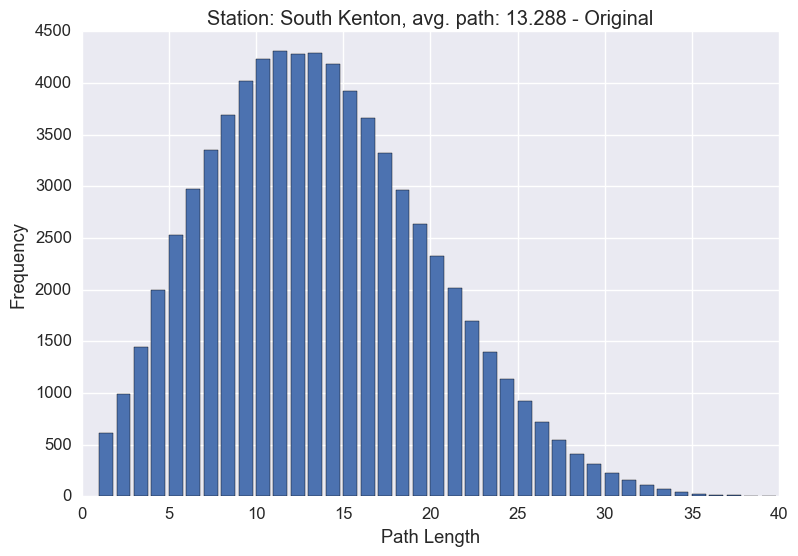

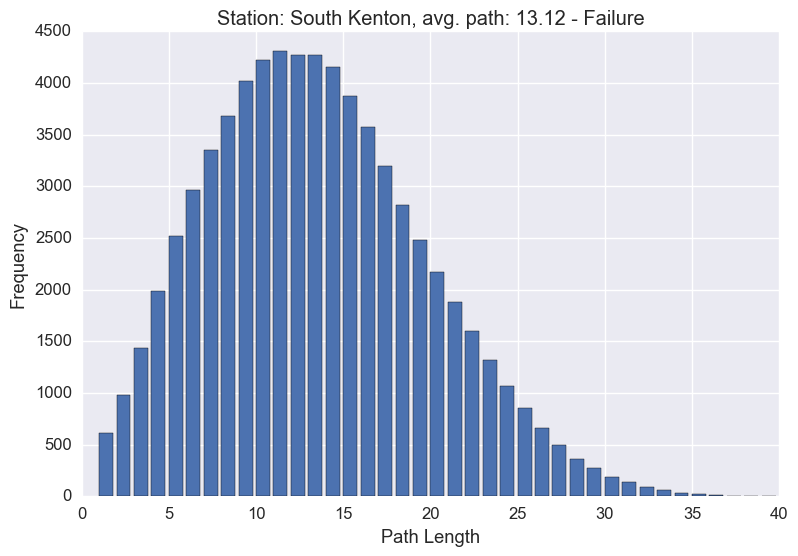

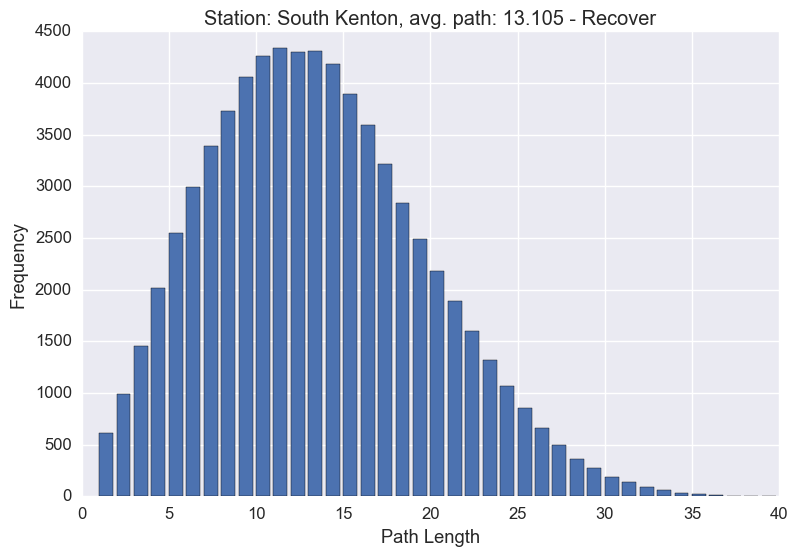

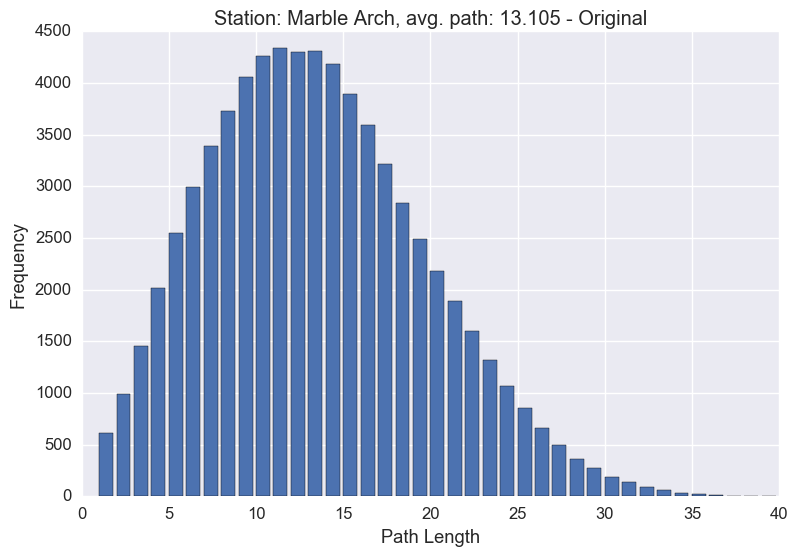

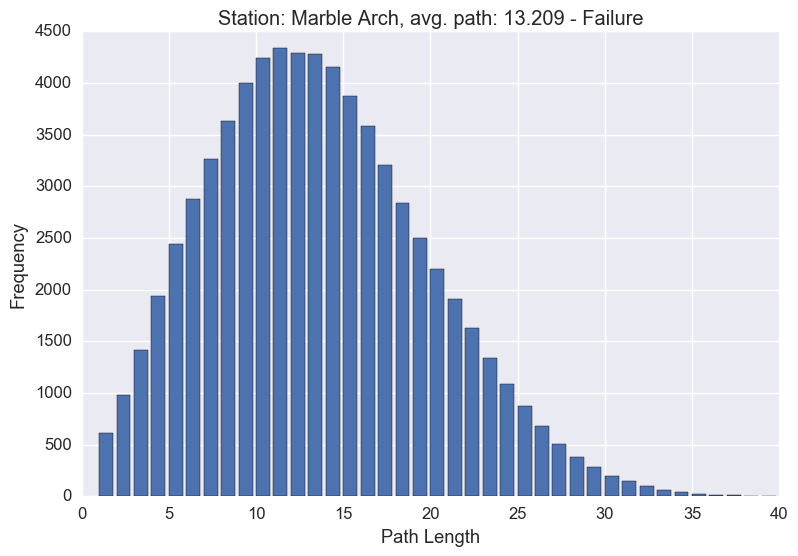

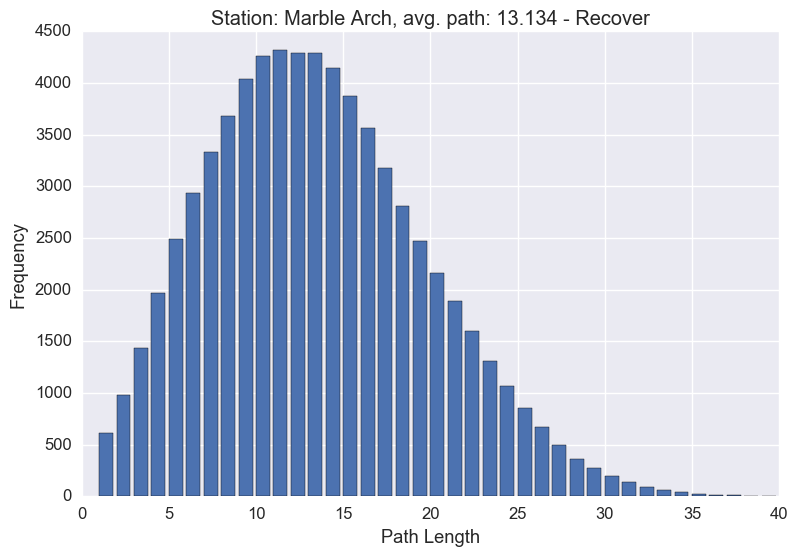

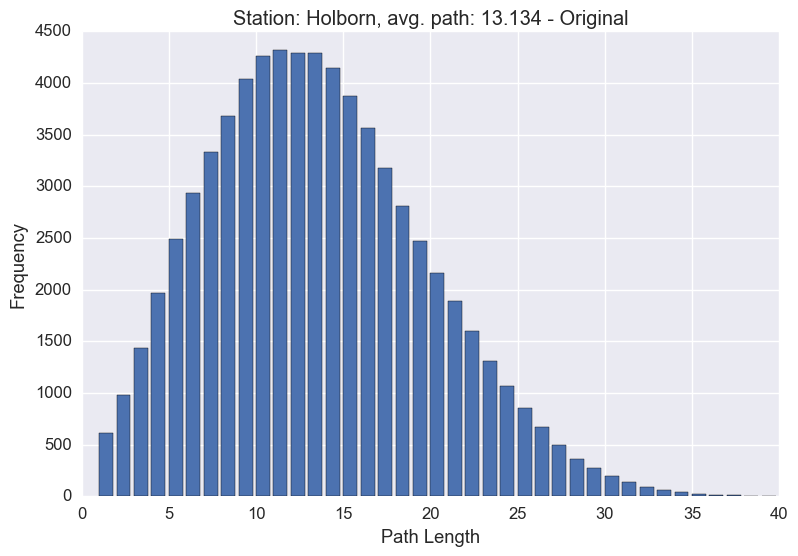

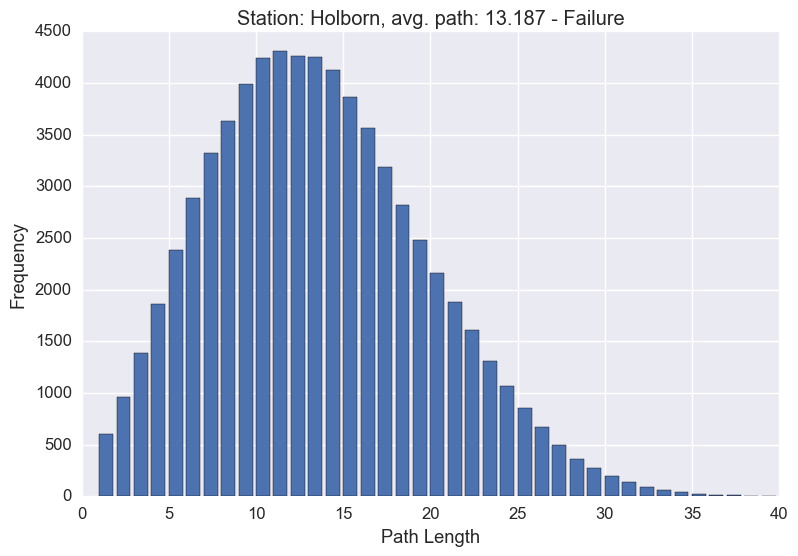

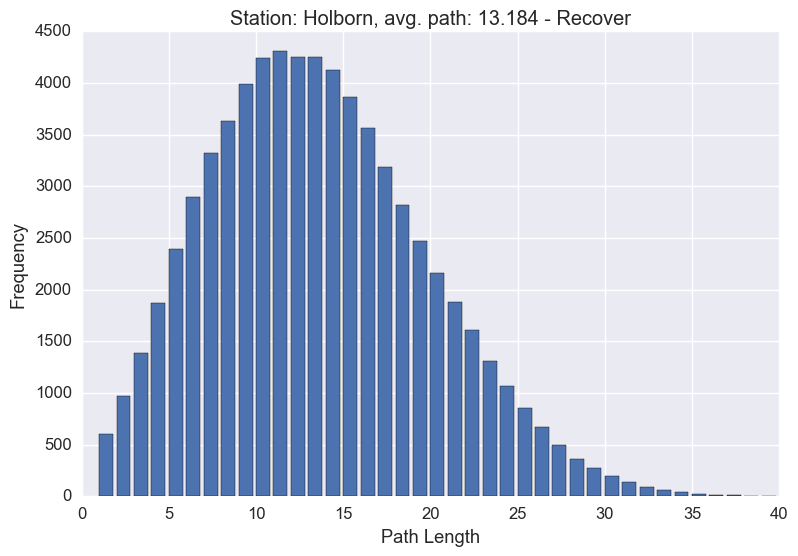

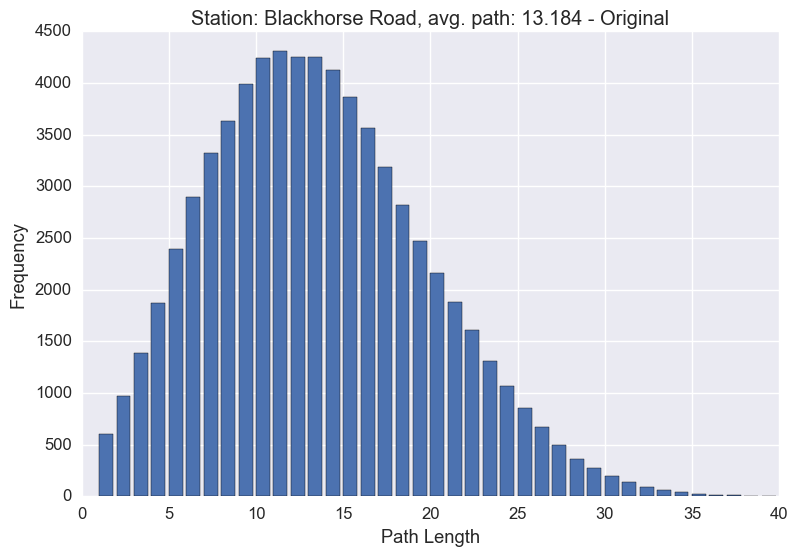

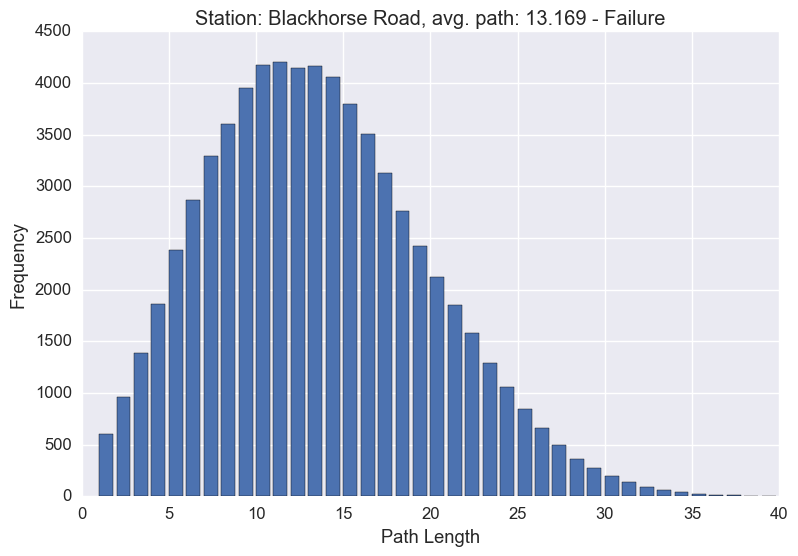

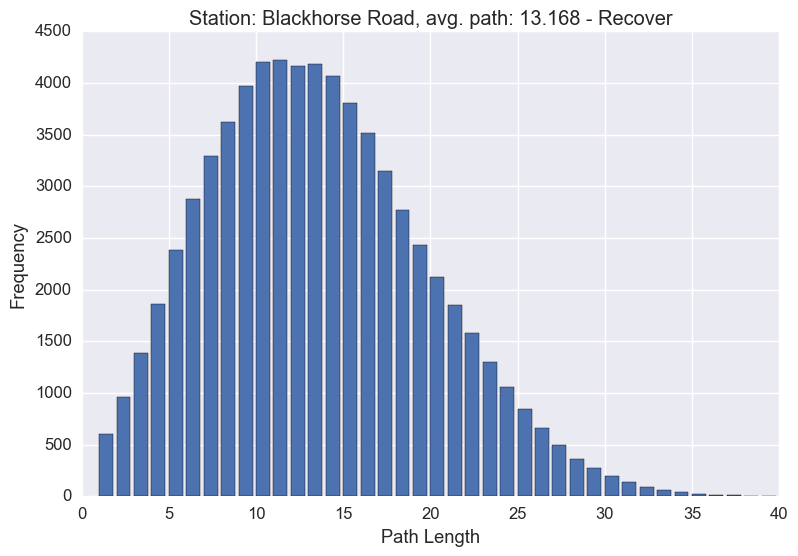

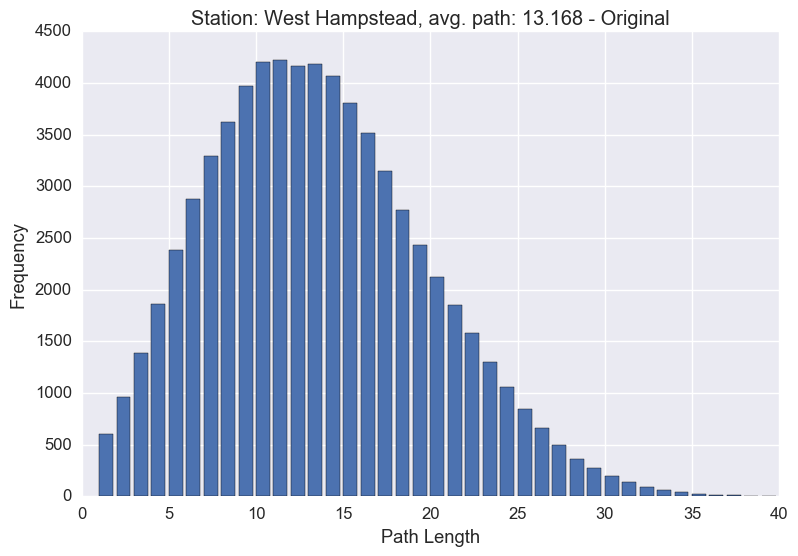

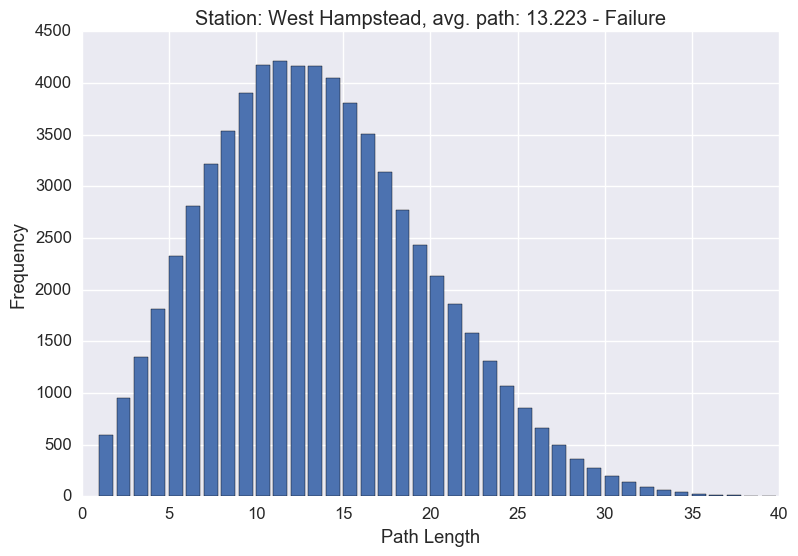

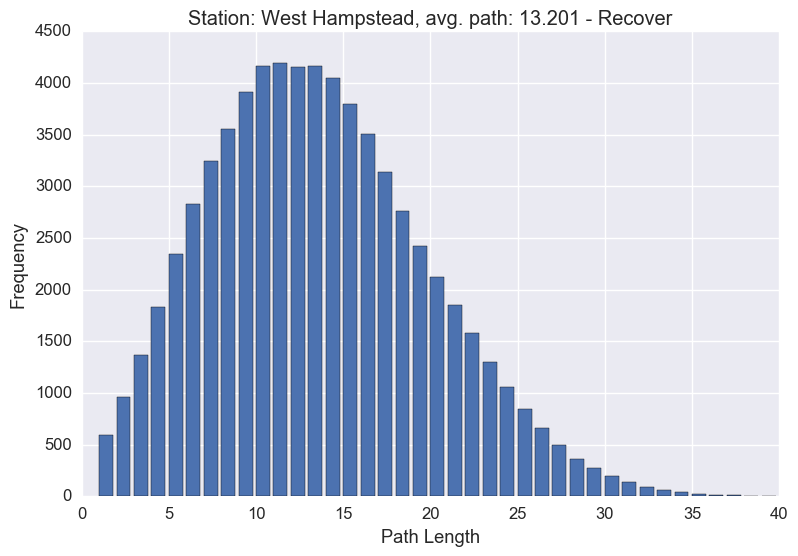

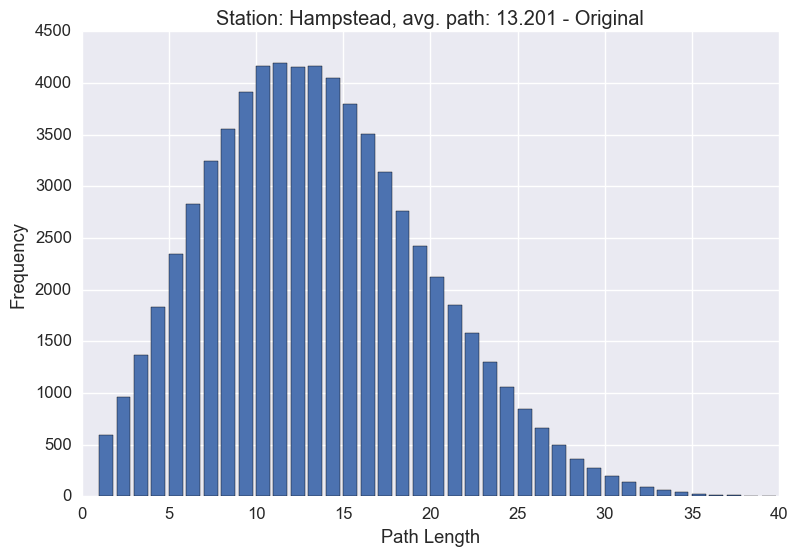

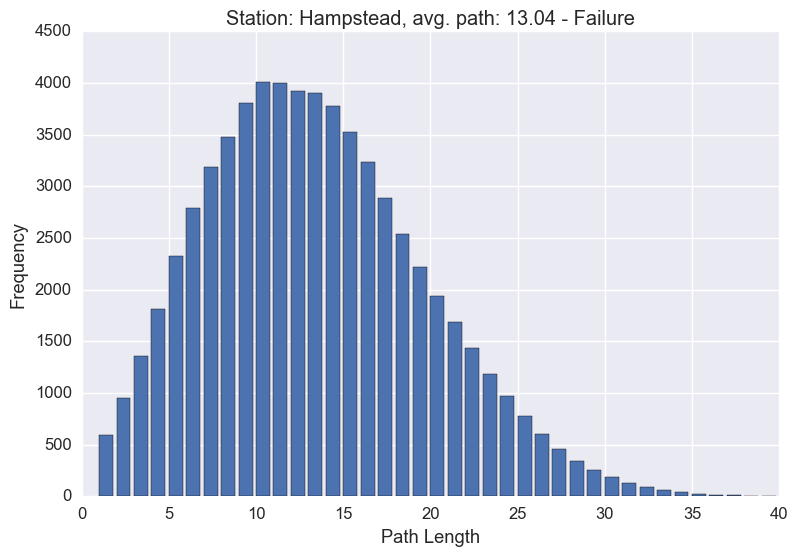

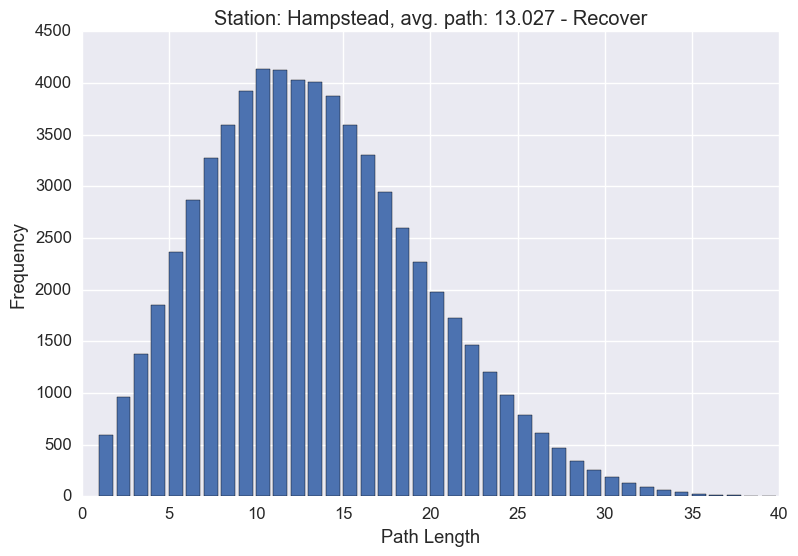

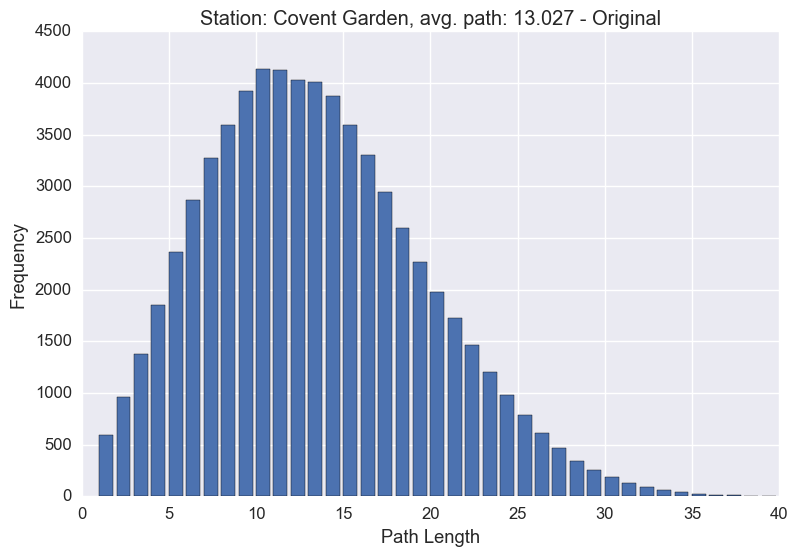

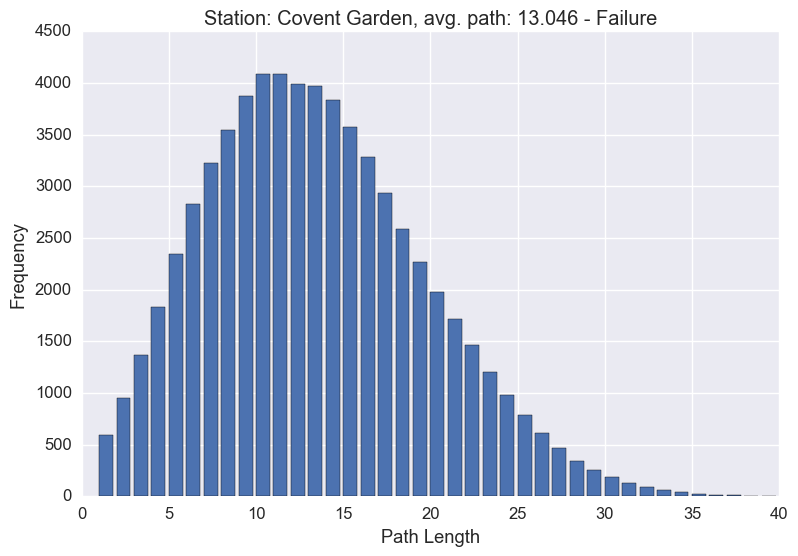

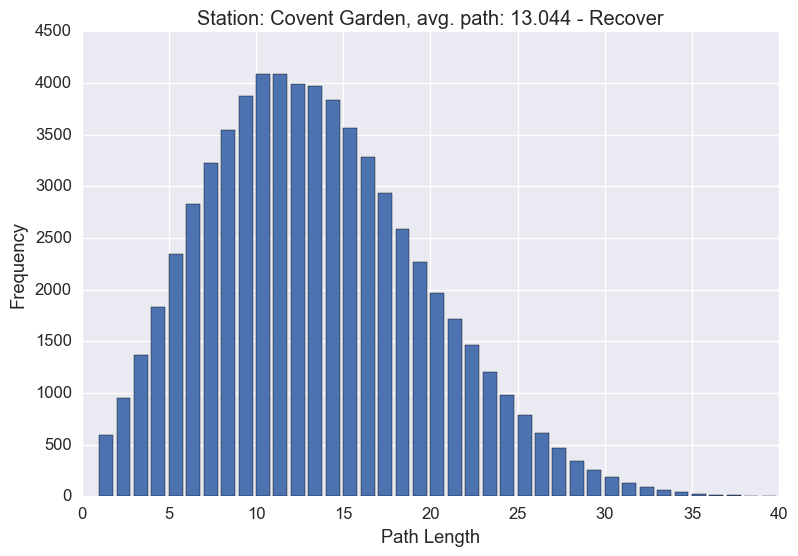

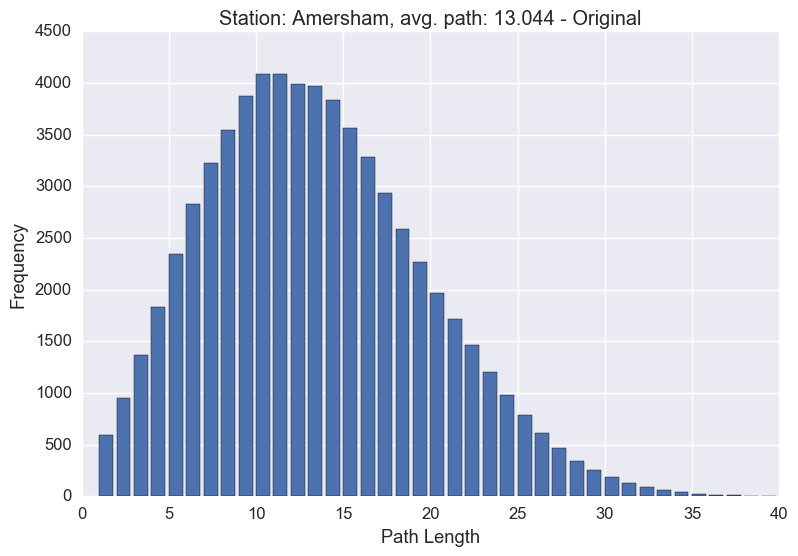

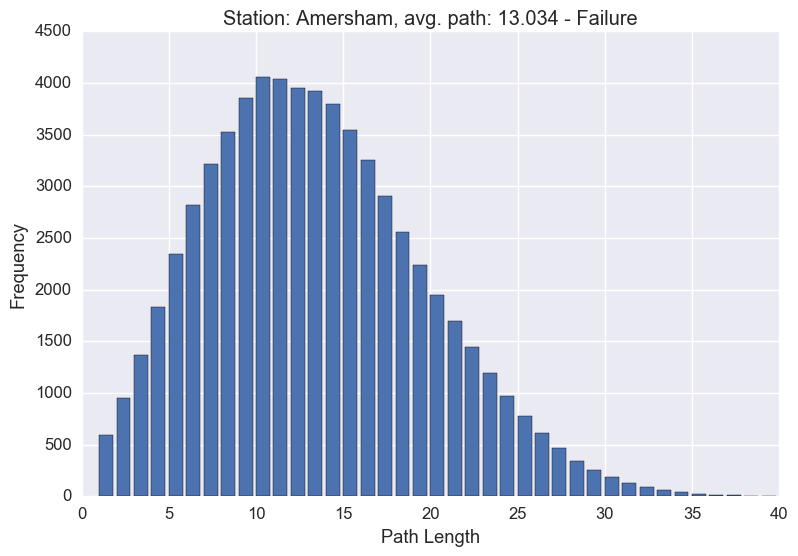

In [7]:
% matplotlib inline

# Create distance matrix (cityblock) using stations coordinates as input
dist_matrix = cdist(proj_pnts, proj_pnts, 'cityblock')

# Select stations with floodrisk greater than 0.3
targets = list(ptn.vs.select(FloodRisk1000a_gt= 0.3))

print(targets)
print('#########')

for node in targets:
    desc = str(node['name'])
    ncl = node['NCL']
    index = np.where(attributes[:,0:1] == desc)[0][0]
    adj_nodes = ptn.neighbors(node, mode=IN)
    
    print(node, 'name:', desc, ' ,NCL:', ncl, ' ,index:', index)
    print('adjacent nodes ID', adj_nodes)
    print('--------------------------')

    path_hist_orig = np.asarray(list(ptn.path_length_hist(directed=True).bins()), dtype=np.int)
    avg_path_orig = round(ptn.average_path_length(directed=True), 3)
    plot_hist(path_hist_orig[:,0::2], desc + ', avg. path: ' + str(avg_path_orig) + ' - Original')
    
    ptn.delete_vertices(node)  # Deletes vertices and all its edges
    path_hist_fail = np.asarray(list(ptn.path_length_hist(directed=True).bins()), dtype=np.int)
    avg_path_fail = round(ptn.average_path_length(directed=True), 3)
    plot_hist(path_hist_fail[:,0::2], desc + ', avg. path: ' + str(avg_path_fail) + ' - Failure')
    
    neighbors = np.where(dist_matrix[index] < 3000)  #index on distance matrix
    ncls = attributes[[neighbors]][0][:,1]  # get NCL codes from attibutes based on index got step ago
    max_bc = max(ptn.vs(NCL_in=ncls)['BetweenCent'])  # find neighbor with max centrality from
    source = ptn.vs(adj_nodes[0])[0]  #need to improve, if node=ncl next
    target = ptn.vs(NCL_in=ncls, BetweenCent_eq=max_bc)[0]
    ptn.add_edge(source, target)
    path_hist_reco = np.asarray(list(ptn.path_length_hist(directed=True).bins()), dtype=np.int)
    avg_path_reco = round(ptn.average_path_length(directed=True), 3)
    plot_hist(path_hist_reco[:,0::2], desc + ', avg. path: ' + str(avg_path_reco) + ' - Recover')
    
    # --- Prints for validation only ---
    print('neighbors matrix', neighbors)
    print('--------------------------')
    print('ncls', ncls)
    print('--------------------------')
    print('max_betweeness', max_bc)
    print('--------------------------')
    print(source)
    print(target)
    print('-------------###############-------------')



# Old code, for backup only

In [ ]:
# % matplotlib inline

# # Create distance matrix (cityblock) using stations coordinates as input
# dist_matrix = cdist(attributes[:,3:5], attributes[:,3:5], 'cityblock')

# # Select stations with floodrisk greater than 0.3
# targets = list(ptn.vs.select(FloodRisk1000a_gt= 0.3))

# for node in targets:
#     desc = node['name']
#     path_hist_orig = list(ptn.path_length_hist(directed=True).bins())
#     avg_path_orig = round(ptn.average_path_length(directed=True), 3)
#     hist_orig = []
#     for bin1 in path_hist_orig:
#         x1 = bin1[0]
#         y1 = bin1[2]
#         hist_orig.append((x1,y1))
#     plot_hist(hist_orig, desc + ', avg. path: ' + str(avg_path_orig) + ' - original')

#     ptn.delete_vertices(node)
#     path_hist_fail = list(ptn.path_length_hist(directed=True).bins())
#     avg_path_fail = round(ptn.average_path_length(directed=True), 3)
#     hist_fail = []
#     for bin2 in path_hist_fail:
#         x2 = bin2[0]
#         y2 = bin2[2]
#         hist_fail.append((x2,y2))

#     plot_hist(hist_fail, desc + ', avg. path: ' + str(avg_path_fail) + ' -  Damaged')

In [ ]:
# edge = ptn.es.select(_source_eq=1, _target_eq=2)  # select source and target node from link
# node = ptn.vs(100)

# Create distance matrix (cityblock) using stations coordinates as input
# dist_matrix = cdist(attributes[:,3:5], attributes[:,3:5], 'cityblock')
# dist_matrix

**Create target list by floooding risk**

In [ ]:
# # Process used during dacas meeting, will be replaced by vertex probaility
# flood = df2[['name','FloodRisk1000a']]
# threshold = flood['name'][flood.FloodRisk1000a > 0.3]
# targets = []

# for i in threshold:
#     targets.append(i)

# ptn2 = ptn.copy()
# targets

In [ ]:
# targets = list(ptn.vs.select(FloodRisk1000a_gt= 0.3))
# targets

**Delete nodes based on Betweeness Centrality**

In [ ]:
# % matplotlib inline

# count = 0

# while count <= 10:
#     max_bc = max(ptn2.vs['beetw_cent'])
#     target = ptn2.vs(ptn2.vs['beetw_cent'] == max_bc)['name']
    
#     path_hist_orig = list(ptn2.path_length_hist(directed=True).bins())
#     hist_orig = []
#     for bin1 in path_hist_orig:
#         x1 = bin1[0]
#         y1 = bin1[2]
#         hist_orig.append((x1,y1))
#     plot_hist(hist_orig, i + str(' original'))

#     ptn2.delete_vertices(ptn2.vs.find(name=i))
#     path_hist_dell = list(ptn2.path_length_hist(directed=True).bins())
#     hist_dell = []
#     for bin2 in path_hist_dell:
#         x2 = bin2[0]
#         y2 = bin2[2]
#         hist_dell.append((x2,y2))
#     plot_hist(hist_dell, 'Damaged')
    
#     count += 1

In [ ]:
# Ploting function
# % matplotlibe inline
# layout = ptn.layout_kamada_kawai()
# plot(ptn, layout = layout)